In [15]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, cross_validate, GroupKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# !pip install spatial-kfold
from spatialkfold.blocks import spatial_blocks 
from spatialkfold.clusters import spatial_kfold_clusters 

from shapely import Point, wkt
import osmnx as ox

import warnings
warnings.filterwarnings('ignore')

random_seed = 100

london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

# 1. Load

In [2]:
df = pd.read_csv('data/cleaned/df_ml_new.csv',low_memory=True)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

In [52]:
# create new columns with log values of target variables
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
for col in timebands:
    df['log_'+col] = df[col].apply(lambda x: 0 if x==0 else np.log(x))
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

Define target variable list

In [5]:
# define target variable columns
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
targets = timebands
# targets_log = ['log_'+t for t in targets]

Define features list

In [6]:
# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'cent_bus_degree','cent_bus_closeness','cent_bus_betweenness',
            'cent_rail_degree','cent_rail_closeness','cent_rail_betweenness'
            ]

# lags as features
lags = ['lag_'+t for t in targets] #to pick one depending on the target

# # features list with xy coordinates
# features_xy = features + ['x_coords','y_coords']

# list with poi_ from features
# features_poi = []
# for col in features:
#     if 'poi_' in col:
#         features_poi.append(col)

# # list with transp_ from features
# features_transp = []
# for col in features:
#     if 'transport_' in col:
#         features_transp.append(col)

# # list with diversity from features
# features_div = []
# for col in features:
#     if 'diversity_' in col:
#         features_div.append(col)

# # list of centrality features
# features_cent = ['cent_bus_degree','bus_closeness_t','bus_betweenness_t','rail_degree','rail_closeness_t','rail_betweenness_t']

# # combine
# features_transp_cent = features_transp + features_cent

EDA

In [ ]:
# for each of the target variable, create a correlation matrix graph
for i,tar in enumerate(targets): 
    print(f'Correlation matrix for {tar}')
    corr = df[[tar] + features_xy + [lags[i]]].corr()
    plt.figure(figsize=(8,8))
    # set 0 as middle value
    plt.matshow(corr, fignum=1, cmap='RdBu',vmin=-1,vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    
    # save the figure
    plt.savefig(os.path.join('output','corr',f'corr_{tar}_log.jpg'))
    plt.show()

# 2. Model selection - Linear, XGBoost, RF, ANN

## Load and Prepare Data

In [ ]:
target_sel = 'Total'
features_sel = features + [lags[targets.index(target_sel)]]

X = df[features_sel]  
y = df["Total"]  

## Define Spatial Cross-Validation

In [20]:
# 2. Define Spatial Cross-Validation
df_point = df.copy()
df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

# spatial kfold
df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 10, algorithm='kmeans',
                                        random_state = random_seed, verbose = True) 
groups = df_clusters["folds"] # Assuming you have a column defining spatial groups 

# Cross-validation setup
group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data
group_kfold = GroupKFold(n_splits=10) # for faster hyperparameter tuning

Initialization complete
Iteration 0, inertia 669708276656.3846.
Iteration 1, inertia 556622288374.3107.
Iteration 2, inertia 523634155347.5055.
Iteration 3, inertia 504628523754.2963.
Iteration 4, inertia 491014146351.51654.
Iteration 5, inertia 481774877637.3202.
Iteration 6, inertia 475936768588.4951.
Iteration 7, inertia 471899867467.47.
Iteration 8, inertia 468900975774.35925.
Iteration 9, inertia 466888894741.24695.
Iteration 10, inertia 465609131140.9203.
Iteration 11, inertia 464745390646.4699.
Iteration 12, inertia 464174424535.8223.
Iteration 13, inertia 463739375344.344.
Iteration 14, inertia 463443414492.00574.
Iteration 15, inertia 463199703139.03784.
Iteration 16, inertia 462933929377.4532.
Iteration 17, inertia 462619284258.0893.
Iteration 18, inertia 462335764970.33234.
Iteration 19, inertia 462091282695.2923.
Iteration 20, inertia 461794874163.27026.
Iteration 21, inertia 461413001506.6301.
Iteration 22, inertia 460825402534.11743.
Iteration 23, inertia 460354008628.462

## Model Selection and Tuning

In [38]:
%%time

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'), 
    "ANN": MLPRegressor(max_iter=500)
}

param_grids = {
    "Linear Regression": {},
    "XGBoost": {
        'max_depth': [8,10,12], #Maximum depth of a tree.
        'subsample': [0.5,0.7,1], #Denotes the fraction of observations to be random samples for each tree
        # 'colsample_bytree': [0.5,0.7], #Denotes the fraction of columns to be random samples for each tree.
        'n_estimators': [2000,3000], # Number of trees in random forest
        'learning_rate': [0.01, 0.001], #learning rate
    },
    "ANN": {
        'hidden_layer_sizes': [(100,100,100,100),(100,100,100,100,100),(100,100,100,100,100,100)], #Number of neurons in each hidden layer
        'learning_rate': ['constant', 'adaptive'], #Learning rate schedule for weight updates
    }
}

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# best hyperparameters for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y, groups=groups)
    best_models[name] = grid_search.best_estimator_
best_models

CPU times: total: 10h 12min 5s
Wall time: 4h 50min 6s


{'Linear Regression': LinearRegression(),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'ANN': MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100, 100), max_iter=500)}

In [46]:
# save best_models dict to file
import joblib
joblib.dump(best_models, 'output/modeltraining/best_models_dict.joblib')

['output/best_models_dict.joblib']

## Model Evaluation

In [ ]:
# # already calibrated
# best_models = {
#     "Linear Regression": LinearRegression(),
#     "XGBoost": XGBRegressor(colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=2000, subsample=0.5),
#     "ANN": MLPRegressor(alpha=0.0001, hidden_layer_sizes=(100,100,100,100,100,100), learning_rate='constant', learning_rate_init=0.001)
# }

In [55]:
%%time
# Try with Total target and features with lags

target_sel = 'Total'
features_sel = features + [lags[targets.index(target_sel)]]

X = df[features_sel]  
y = df["Total"]  

for name, model in best_models.items():
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    print(f"\n{name}:")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R^2: {np.mean(r2_scores)}")

    if name == "Linear Regression":
        r2_lr = np.mean(r2_scores)
        mae_lr = np.mean(mae_scores)
        mse_lr = np.mean(mse_scores)
    elif name == "ANN":
        r2_ann = np.mean(r2_scores)
        mae_ann = np.mean(mae_scores)
        mse_ann = np.mean(mse_scores)
    elif name == "XGBoost":
        r2_xgb = np.mean(r2_scores)
        mae_xgb = np.mean(mae_scores)
        mse_xgb = np.mean(mse_scores)
    
# put R2 into a dataframe
r2_df = pd.DataFrame({
    'model': ['Linear Regression', 'ANN', 'XGBoost'],
    'r2': [r2_lr, r2_ann, r2_xgb],
    'mae': [mae_lr, mae_ann, mae_xgb],
    'mse': [mse_lr, mse_ann, mse_xgb]})
r2_df.to_csv('output/modeltraining/r2_scores_scaled.csv',index=False)
r2_df


Linear Regression:
Mean MAE: 3533.117697245712
Mean MSE: 5671.784454419826
Mean R^2: 0.576167934720002

XGBoost:
Mean MAE: 2780.091969695105
Mean MSE: 5276.138910587806
Mean R^2: 0.7163525304020167

ANN:
Mean MAE: 3265.1304251266474
Mean MSE: 6273.826831899998
Mean R^2: 0.5263548861921235
CPU times: total: 36min 53s
Wall time: 1h 11min 53s


,model,r2,mae,mse
0,Linear Regression,0.576168,3533.117697,5671.784454
1,ANN,0.526355,3265.130425,6273.826832
2,XGBoost,0.716353,2780.091970,5276.138911


Try again for sanity check if using log_Total

In [57]:
%%time
### Try again with log_ target instead

X = df[features_sel]  
y = df["log_Total"]

# Cross-validation setup
group_cvs =  LeaveOneGroupOut()

for name, model in best_models.items():
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X_.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    print(f"\n{name}:")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R^2: {np.mean(r2_scores)}")

    if name == "Linear Regression":
        r2_lr = np.mean(r2_scores)
        mae_lr = np.mean(mae_scores)
        mse_lr = np.mean(mse_scores)
    elif name == "ANN":
        r2_ann = np.mean(r2_scores)
        mae_ann = np.mean(mae_scores)
        mse_ann = np.mean(mse_scores)
    elif name == "XGBoost":
        r2_xgb = np.mean(r2_scores)
        mae_xgb = np.mean(mae_scores)
        mse_xgb = np.mean(mse_scores)
    
# put R2 into a dataframe
r2_df = pd.DataFrame({
    'model': ['Linear Regression', 'ANN', 'XGBoost'],
    'r2': [r2_lr, r2_ann, r2_xgb],
    'mae': [mae_lr, mae_ann, mae_xgb],
    'mse': [mse_lr, mse_ann, mse_xgb]})
r2_df.to_csv('output/modeltraining/r2_scores_logTotal_scaled.csv',index=False)
r2_df


Linear Regression:
Mean MAE: 0.6882423322802039
Mean MSE: 0.9671287248264324
Mean R^2: 0.6973225532445182

XGBoost:
Mean MAE: 0.5636661056632363
Mean MSE: 0.8097891075017204
Mean R^2: 0.791913812272219

ANN:
Mean MAE: 0.7452701731858534
Mean MSE: 1.1540121970394674
Mean R^2: 0.41032323508302576
CPU times: total: 57min 4s
Wall time: 3h 16min 35s


,model,r2,mae,mse
0,Linear Regression,0.697323,0.688242,0.967129
1,ANN,0.410323,0.745270,1.154012
2,XGBoost,0.791914,0.563666,0.809789


In [58]:
%%time
### Try again with log_ target instead, not scaled

X = df[features_sel]  
y = df["log_Total"]

# Cross-validation setup
group_cvs =  LeaveOneGroupOut()

for name, model in best_models.items():
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X_.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # # Standardize the data
        # scaler = StandardScaler()
        # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    print(f"\n{name}:")
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R^2: {np.mean(r2_scores)}")

    if name == "Linear Regression":
        r2_lr = np.mean(r2_scores)
        mae_lr = np.mean(mae_scores)
        mse_lr = np.mean(mse_scores)
    elif name == "ANN":
        r2_ann = np.mean(r2_scores)
        mae_ann = np.mean(mae_scores)
        mse_ann = np.mean(mse_scores)
    elif name == "XGBoost":
        r2_xgb = np.mean(r2_scores)
        mae_xgb = np.mean(mae_scores)
        mse_xgb = np.mean(mse_scores)
    
# put R2 into a dataframe
r2_df = pd.DataFrame({
    'model': ['Linear Regression', 'ANN', 'XGBoost'],
    'r2': [r2_lr, r2_ann, r2_xgb],
    'mae': [mae_lr, mae_ann, mae_xgb],
    'mse': [mse_lr, mse_ann, mse_xgb]})
r2_df.to_csv('output/modeltraining/r2_scores_logTotal.csv',index=False)
r2_df


Linear Regression:
Mean MAE: 0.6882423322802139
Mean MSE: 0.9581722601910269
Mean R^2: 0.6973225532445323

XGBoost:
Mean MAE: 0.5634388722200229
Mean MSE: 0.6866800199009498
Mean R^2: 0.7922318723788635


In [ ]:
# Choose the best model with the highest R^2
best_model = best_models["XGBoost"]
best_model.fit(X, y) # Fit the model with all data

# Save the model
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

# 3. Estimate marginal contribution to R2

In [ ]:
# iterate through features_sel, remove one feature at a time and calculate the R2, and also with spatial cross validation

# Load the best model
model = joblib.load('best_model.pkl')

results_perm = pd.DataFrame()

for train_index, test_index in group_kfold.split(X, y, groups=groups):
    # Split train-test based on spatial cross-validation
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    r2_without = []

    # Train the model
    scaler = StandardScaler()
    for f in features_sel:  
        X_train_new = X_train.drop(columns=[f])
        X_test_new = X_test.drop(columns=[f])
        X_train_scaled_new = scaler.fit_transform(X_train_new)
        X_test_scaled_new = scaler.transform(X_test_new)

        # Fit the model
        model.fit(X_train_scaled_new, y_train)
        y_pred = model.predict(X_test_scaled_new)

        # Calculate R2 score when removing each feature
        r2 = r2_score(y_test, y_pred)
        r2_without.append(r2)

    # convert to array and add to the dataframe
    r2_without_ = np.array(r2_without)
    results_perm = pd.concat([
        results_perm,
        pd.DataFrame({
            'Feature': features_sel, 
            'R2_without': r2_without_
            })
    ])

# group by feature and calculate the mean of the R2_without
results_perm = results_perm.groupby('Feature').mean().reset_index()

# marginal contribution compared to the full model
results_perm['R2_diff'] = r2_xgb - results_perm['R2_without'] 
results_perm.sort_values('R2_diff', ascending=False, inplace=True)
results_perm

,Feature,R2_without,R2_diff
9,lag_Total,0.622512,0.093755
8,diversity_transp_opt,0.684068,0.032199
22,population,0.706001,0.010265
25,transport_rail,0.709036,0.007231
10,poi_banking,0.709602,0.006664
1,cent_bus_closeness,0.710159,0.006107
6,diversity_poi,0.711743,0.004523
12,poi_leisure_active,0.712076,0.004191
7,diversity_transp_mode,0.712422,0.003844
14,poi_leisure_outdoor,0.712504,0.003762


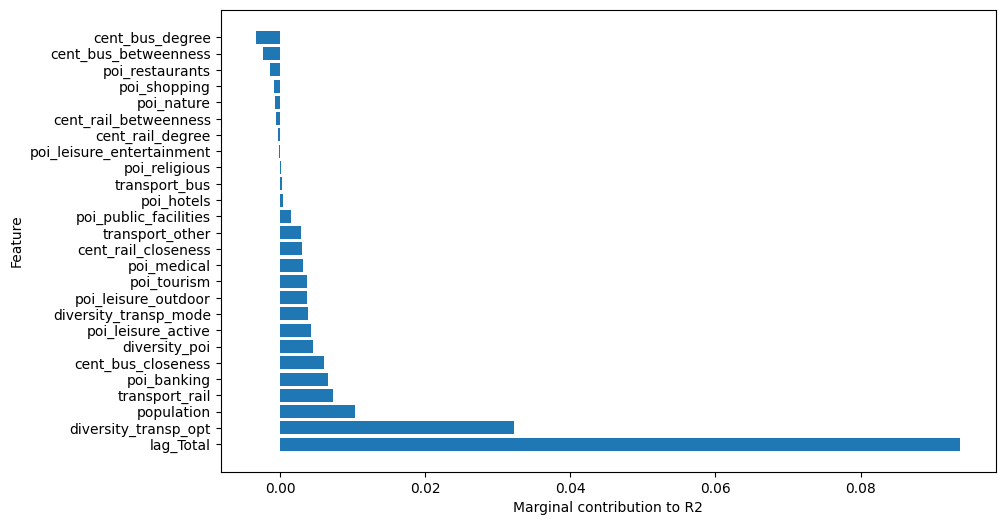

In [ ]:
# plot 2 columns
plt.figure(figsize=(10,6))
plt.barh(results_perm['Feature'], results_perm['R2_diff'])
plt.xlabel('Marginal contribution to R2')
plt.ylabel('Feature')
plt.savefig('output/marginal_contribution.jpg')
plt.show()